In [2]:
from random import *
from math import *
from copy import *
from statistics import mean 
from IPython.display import Image
import cairocffi as cairo

## Visualisation tools

In [3]:
from dataclasses import dataclass

import cairocffi as cairo

@dataclass
class Vector2i():
    x: int = 0
    y: int = 0

class Visualizer():
    def __init__(self,
                 width=800,
                 height=800,
                 grid_draw=True,
                 x_offset=0.1,
                 y_offset=0.1):
        self.height = height
        self.width = width
        self.grid_draw = grid_draw
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, height, width)
        self.context = cairo.Context(self.surface)

    def draw_gantt(self, scheduler, filename):
        self._setup_canvas()
        max_time = self._setup_xaxis(scheduler.work_duration())
        num_servers = self._setup_yaxis(scheduler.server_count)
        width_scaling = self._scale_axis(self.x_offset, max_time)
        height_scaling = self._scale_axis(self.y_offset, num_servers)

        jobs_colors = {
            j_id: self._generate_color()
            for j_id in scheduler.job_ids()
        }

        ids = scheduler.server_ids()
        servers_ypos = {
            id: ypos
            for id, ypos in zip(ids, self._server_yposition(ids))
        }

        for task in scheduler.tasks:
            j_id = task.job_id
            t_time = task.end_time - task.start_time
            for server in task.servers:
                alpha = 0.5 if isinstance(task, Reconfiguration) else 1.0
                tl = Vector2i(self.x_offset + task.start_time * width_scaling,
                              servers_ypos[server.id])
                size = Vector2i(width_scaling * t_time, height_scaling)
                self._draw_rectangle(tl=tl,
                                     size=size,
                                     r=jobs_colors[j_id][0],
                                     g=jobs_colors[j_id][1],
                                     b=jobs_colors[j_id][2],
                                     alpha=alpha)

        if (self.grid_draw):
            self._draw_grid(scheduler.work_duration(), num_servers)

        self.context.set_font_size(0.05)
        self._set_labels(xlabel="Time",
                         xlabel_pos=Vector2i(0.8, 0.97),
                         ylabel="Servers",
                         ylabel_pos=Vector2i(0, 0.07))
        self._save_to(filename)

    def _setup_canvas(self, height=800, width=800):
        self._normalize_canvas()
        self._draw_rectangle()

    def _normalize_canvas(self):
        self.context.scale(self.height, self.width)

    def _setup_xaxis(self, xmax):
        return 1.01 * xmax

    def _setup_yaxis(self, ymax):
        return ymax

    def _scale_axis(self, offset, max_value):
        return (1 - offset * 2) / max_value

    def _generate_color(self):
        return [random() for j in range(3)]

    def _server_yposition(self, servers):
        y_positions = []
        server_count = len(servers)
        height_scaling = self._scale_axis(self.y_offset, server_count)
        for i in range(server_count):
            y_positions.append(self.y_offset + i * height_scaling)
        return y_positions

    def _draw_rectangle(self,
                        tl=Vector2i(),
                        size=Vector2i(1,1),
                        r=1,
                        g=1,
                        b=1,
                        alpha=1.0):
        self.context.rectangle(tl.x, tl.y, size.x, size.y)
        self._set_color(r, g, b, alpha)
        self.context.fill()

    def _set_color(self, r=0, g=0, b=0, alpha=1.0):
        self.context.set_source_rgba(r, g, b, alpha)

    def _draw_grid(self, xmax, ymax):
        scaled_x = self._setup_xaxis(xmax)
        width_scaling = self._scale_axis(self.x_offset, scaled_x)
        height_scaling = self._scale_axis(self.y_offset, ymax)

        for i in range(ceil(xmax) + 1):
            pos = Vector2i(self.x_offset + i * width_scaling, self.y_offset)
            self._move_cursor(pos)
            pos.y = 1 - pos.y
            self._draw_line(pos)

        for j in range(ymax + 1):
            pos = Vector2i(self.x_offset, self.y_offset + j * height_scaling)
            self._move_cursor(pos)
            pos.x += xmax
            self._draw_line(pos)

    def _move_cursor(self, position):
        self.context.move_to(position.x, position.y)

    def _draw_line(self, position, line_width=0.001, r=0, g=0, b=0, alpha=0.9):
        self.context.line_to(position.x, position.y)
        self._set_color(r, g, b, alpha)
        self.context.set_line_width(line_width)
        self.context.stroke()

    def _set_labels(self, xlabel, xlabel_pos, ylabel, ylabel_pos):
        self._move_cursor(xlabel_pos)
        self.context.show_text(xlabel)

        self._move_cursor(ylabel_pos)
        self.context.show_text(ylabel)

    def _save_to(self, filename):
        self.surface.write_to_png(filename)


## Objective:

minimize(max $\frac{t_{termination} - t_{submission}}{mass})$

## Job class
Initial parameters: <br>
- name : unique id of the job<br>
- sub_time: submission time<br>
- alpha : speed up factor (can be thought of as the communication time), should be somewhere between 0.5 and 1
- data: data to be processed, required for the reconfiguration time (see equation below)
- mass: mass of computation : area if run with one server 
- min_num_servers : minimum number of servers required for the job to be run
- max_num_servers : maximum number of servers the job should be run on
<br>



### Jobs and tasks
A job is broken into smaller tasks that can be processed on a different amount of servers. The number of servers used will impact the processing time according to the equation shown below.


### Processing time of a task
$time = \frac{mass}{(num\_servers)^{alpha}}$<br>
or<br>
$mass= time \times (num\_servers)^{alpha}$


### Reconfiguration time
Time required to reconfigure the data if the number of servers is either increased or decreased. <br>
if $n\geq m$:<br>
$T_{n\rightarrow m} = \frac{D}{n}(\lceil \frac{n}{m}\rceil - 1)$<br>
if $n\leq m$:<br>
$T_{n\rightarrow m} = \frac{D}{m}(\lceil \frac{m}{n}\rceil - 1)$<br>

where $D$ is the data amount in the application, $n$ number of servers in the previous process and $m$ the number of servers in the new process

In [4]:
class Job():
    def __init__(self, id, sub_time, alpha, data, mass, min_num_servers,
                 max_num_servers):
        self.id = id
        self.sub_time = sub_time
        self.alpha = alpha
        self.data = data
        self.mass = mass
        self.min_num_servers = min_num_servers
        self.max_num_servers = max_num_servers

    def __eq__(self, other):
        return self.id == other.id


## Task class
Initial parameters: <br>
- job_name: The job to which the task belongs
- start_time
- end_time
- mass_executed
- servers : list of servers the task is executed on

In [5]:
class Task(object):
    def __init__(self, job_id, mass_executed, servers, start_time, end_time):
        self.job_id = job_id
        self.mass_executed = mass_executed
        self.servers = servers
        self.start_time = start_time
        self.end_time = end_time

    def __repr__(self):
        return "name: {}, mass_exec: {}, #servers: {} start_time: {}, end_time: {}".format(
            self.job_id, self.mass_executed, len(self.servers),
            self.start_time, self.end_time)

    def from_job(self, job):
        return self.job_id == job.id



class Reconfiguration(Task):
    def __init__(self, job_id, servers, start_time, end_time):
        Task.__init__(self, job_id, 0, servers, start_time, end_time)

    def __str__(self):
        return "name: {}, reconfiguration, mass_exec: {}, #servers: {} start_time: {}, end_time: {}".format(
            self.job_id, self.mass_executed, len(self.servers),
            self.start_time, self.end_time)

  

## Server

A server is a computation unit 

In [6]:
class Server():
    def __init__(self, id):
        self.id = id

    def __eq__(self, other):
        return self.id == other.id

## Scheduler - state of whole thing

Manager should be able to access objects and query.<br>

In [7]:
class Scheduler(object):
    def __init__(self, servers):
        self.servers = servers
        self.jobs = []
        self.tasks = []
        self.job_queued = []

    def schedule(self, job):
        self.jobs.append(job)

        #schedule the first job into one task
        if len(self.tasks) == 0:
            self._schedule_task(self.servers, job, job.sub_time)
        #Schedule the jobs
        else:
            #Get the servers available at submission time
            available_servers = self._available_servers(job.sub_time)
            if (len(available_servers) < job.min_num_servers):
                self.job_queued.append(job)
                return
            #Schedule task
            else:
                self._schedule_task(available_servers, job, job.sub_time)

    def update_schedule(self, time):
        #get the free servers
        available_servers = self._available_servers(time + 0.01)
        num_available_servers = len(available_servers)

        print('Number of available servers at update: ', num_available_servers)

        #Check if there is job queued
        if (self.job_queued):
            #Try to schedule each job
            for job in self.job_queued:
                if (num_available_servers > job.min_num_servers):
                    self._schedule_task(available_servers, job, time)
                    #remove job from queue
                    self.job_queued.remove(job)
                    #update list of servers available
                    available_servers = self._available_servers(time + 0.01)
                    num_available_servers = len(available_servers)

        #find tasks that could be reconfigured
        #List of tasks for which the possible change of the number of servers is greater than 0
        tasks_candidates = [
            t for t in self.tasks if
            self._task_possible_inc_num_ser(t, time, num_available_servers) > 0
        ]

        if (len(tasks_candidates) == 0):
            return

        def reconfigure_task(task):
            # Return the list of new servers to execute the task
            def reallocate_task_servers(task):
                extra_srv_count = self._task_possible_inc_num_ser(
                    task, time, num_available_servers)
                task_servers = [s for s in task.servers]
                for i in range(extra_srv_count):
                    task_servers.append(available_servers[i])
                return task_servers

            # Reconfigure and update the task
            # Update the task end_time and mass_executed.
            def interrupt_task(task, job):
                task.end_time = time
                exec_time = task.end_time - task.start_time
                task.mass_executed = self._mass_exec(job.alpha,
                                                     len(task.servers),
                                                     exec_time)

        #Create a new task for reconfiguration

            def make_reconfiguration(job, servers):
                reconfig_time = self._reconfig_time(job.data,
                                                    len(task.servers),
                                                    len(servers))
                reconfig_end_time = time + reconfig_time
                reconfig = Reconfiguration(job.id, servers, time,
                                           reconfig_end_time)
                self.tasks.append(reconfig)
                return reconfig

            # Create a task to finish job after reconfig
            def reschedule_interrupted(job, reconfig, servers):
                mass_left = job.mass - self._mass_executed(job, time)
                exec_time = self._exec_time(mass_left, job.alpha, len(servers))
                start_time = reconfig.end_time
                end_time = reconfig.end_time + exec_time
                mass_executed = mass_left
                self.tasks.append(
                    Task(job.id, mass_executed, servers, start_time, end_time))

            task_job = self._task_job(task)
            task_servers = reallocate_task_servers(task)
            interrupt_task(task, task_job)
            reconfig = make_reconfiguration(task_job, task_servers)
            reschedule_interrupted(task_job, reconfig, task_servers)

        task_to_reconfig = tasks_candidates[0]
        reconfigure_task(task_to_reconfig)

    # returns a list of servers not utilized at a given time
    def _available_servers(self, time):
        #Start with all servers as potential servers
        candidate_servers = [s for s in servers]
        #remove servers that are busy at the given time
        for t in self.tasks:
            if not (t.start_time < time and t.end_time > time):
                continue
            for s in t.servers:
                if s in candidate_servers:
                    candidate_servers.remove(s)
        return candidate_servers

    def _schedule_task(self, servers, job, time):
        num_servers = min(job.max_num_servers, len(servers))
        servers = sample(servers, k=num_servers)
        exec_time = self._exec_time(job.mass, job.alpha, num_servers)
        self.tasks.append(
            Task(job.id, job.mass, servers, time, time + exec_time))

    # Returns the possible increase in the number of servers for a task
    # given that num_servers are not busy
    def _task_possible_inc_num_ser(self, task, time, num_servers):
        #job = list(filter(lambda j: (j.id == task.job_id), self.jobs))[0]
        if (task.end_time <= time):
            return 0
        job = next(j for j in self.jobs if (j.id == task.job_id))
        task_num_servers = len(task.servers)
        if (task_num_servers == job.max_num_servers):
            return 0
        elif (task_num_servers + num_servers > job.max_num_servers):
            return job.max_num_servers - task_num_servers
        else:
            return num_servers

    # Formula for communication time
    def _mass_exec(self, alpha, num_serv, exec_time):
        return exec_time * (num_serv)**alpha

    def _exec_time(self, mass, alpha, num_serv):
        return mass / (num_serv)**alpha

    #Calculates the reconfiguration time
    def _reconfig_time(self, data, init_servers, final_servers):
        if init_servers > final_servers:
            return data / init_servers * (ceil(init_servers / final_servers) -
                                          1)
        return data / final_servers * (ceil(final_servers / init_servers) - 1)

    #Finds how much mass has been executing of job
    def _mass_executed(self, job, time):
        mass_ex = 0
        for t in self.tasks:
            if t.job_id == job.id:
                mass_ex += t.mass_executed
        return mass_ex

    # Returns the makespan
    def work_duration(self):
        min_time = min([t.start_time for t in self.tasks])
        max_time = max([t.end_time for t in self.tasks])
        return max_time - min_time

    def job_ids(self):
        return [j.id for j in self.jobs]

    def server_ids(self):  # server_id_list
        return [s.id for s in self.servers]

    @property
    def server_count(self):
        return len(self.servers)

    #Returns the job that a task is executing
    def _task_job(self, task):
        return next(j for j in self.jobs if task.from_job(j))

        #TODO
    def jobs_reconfigured(self):
        return []  #array of jobs

    def num_jobs_reconfigured(self):
        return len(self.jobs_reconfigured())

    def stretch_time(self, job):
        #find the termination time from the tasks of that job and subtime, divide the difference by the mass
        term_time = -1
        for t in self.tasks:
            if t.job_id == job.id and t.end_time > term_time:
                term_time = t.end_time
        return (term_time - job.sub_time) / job.mass

    def stretch_times(self):
        #array of all the stretch times
        return [self.stretch_time(j) for j in self.jobs]

    def average_stretch_time(self):
        return mean(self.stretch_times())

    def max_stretch_time(self):
        return max(self.stretch_times())


Instantiating the different jobs to be processed and servers

In [8]:
job1 = Job('job1', sub_time = 0, alpha = 1, data = 10, mass = 10, min_num_servers = 2, max_num_servers=3)
job2 = Job('job2', sub_time = 1, alpha = 1, data = 10, mass = 20, min_num_servers = 1, max_num_servers=4)
job3 = Job('job3', sub_time = 6, alpha = 0.5, data = 3, mass = 15, min_num_servers = 1, max_num_servers=5)
job4 = Job('job4', sub_time = 12, alpha = 0.9, data = 10, mass = 35, min_num_servers = 1, max_num_servers=4)
jobs = [job1, job2, job3, job4]
#Sort jobs by submission time
jobs = sorted(jobs, key=lambda k: k.sub_time) 

servers = [Server('server'+str(i)) for i in range(6)]

Initialize the scheduler

In [9]:
scheduler = Scheduler(servers)

In [10]:
for t in range(50):
    print('time: ', t)
    for job in jobs:
        if job.sub_time<=t:
            print('scheduling job:', job.id)
            scheduler.schedule(job)
            jobs.remove(job)
        else:
            break
    scheduler.update_schedule(t)
    
    for task in scheduler.tasks:
        print(task)
    print()

time:  0
scheduling job: job1
Number of available servers at update:  3
name: job1, mass_exec: 10, #servers: 3 start_time: 0, end_time: 3.3333333333333335

time:  1
scheduling job: job2
Number of available servers at update:  0
name: job1, mass_exec: 10, #servers: 3 start_time: 0, end_time: 3.3333333333333335
name: job2, mass_exec: 20, #servers: 3 start_time: 1, end_time: 7.666666666666667

time:  2
Number of available servers at update:  0
name: job1, mass_exec: 10, #servers: 3 start_time: 0, end_time: 3.3333333333333335
name: job2, mass_exec: 20, #servers: 3 start_time: 1, end_time: 7.666666666666667

time:  3
Number of available servers at update:  0
name: job1, mass_exec: 10, #servers: 3 start_time: 0, end_time: 3.3333333333333335
name: job2, mass_exec: 20, #servers: 3 start_time: 1, end_time: 7.666666666666667

time:  4
Number of available servers at update:  3
name: job1, mass_exec: 10, #servers: 3 start_time: 0, end_time: 3.3333333333333335
name: job2, mass_exec: 9, #servers: 3 

In [11]:
scheduler.stretch_times()

[0.33333333333333337, 0.4125, 0.625225453624311, 0.582926064320772]

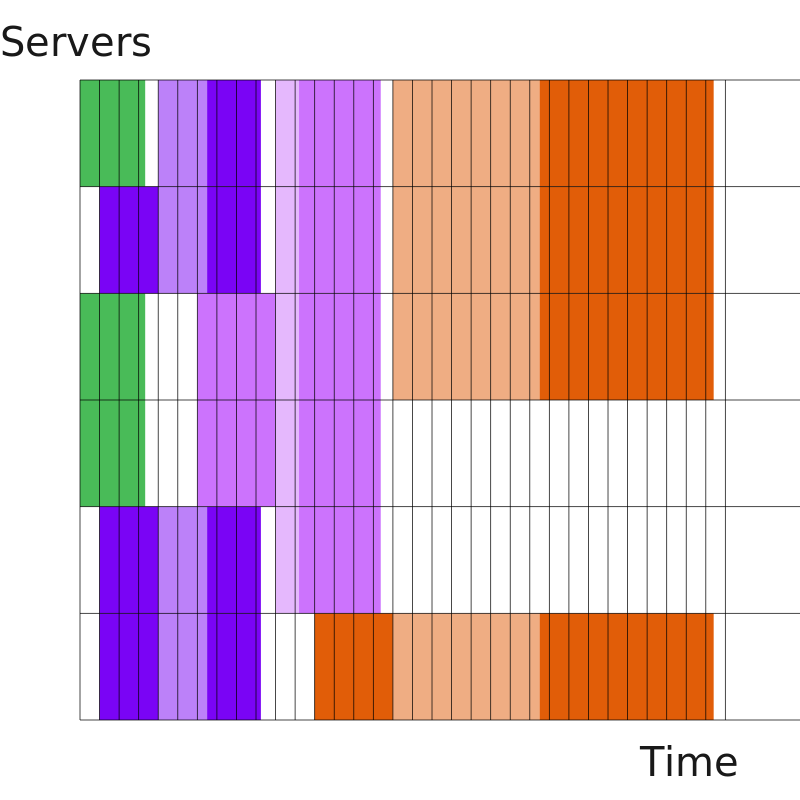

In [12]:
vz = Visualizer(width=800, height=800)
file_name = 'test_2.png'
vz.draw_gantt(scheduler, file_name)
Image(filename = file_name, width=500, height=500)